<a href="https://colab.research.google.com/github/NeilaBouali/Hackathon-IA/blob/main/Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import needed modules

In [ ]:
!pip install --upgrade pip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 63.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [ ]:
!pip install opencv-python

In [ ]:
!pip install kaggle


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


## Data Preprocessing

Read data and store it in dataframe

In [ ]:
import os
import shutil

# Crée le dossier ~/.kaggle si besoin
kaggle_dir = os.path.expanduser('~/.kaggle')
os.makedirs(kaggle_dir, exist_ok=True)

# Copie kaggle.json dans ~/.kaggle
shutil.copy('kaggle.json', os.path.join(kaggle_dir, 'kaggle.json'))

# Change les permissions (Windows n'en a pas vraiment besoin mais pour compatibilité)
os.chmod(os.path.join(kaggle_dir, 'kaggle.json'), 0o600)

print("✅ Clé Kaggle installée avec succès.")


✅ Clé Kaggle installée avec succès.


In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

api.dataset_download_files(
    'sumithsingh/blood-cell-images-for-cancer-detection',  # correction ici
    path='dataset',
    unzip=True
)

print("✅ Dataset téléchargé et extrait.")

Dataset URL: https://www.kaggle.com/datasets/sumithsingh/blood-cell-images-for-cancer-detection
✅ Dataset téléchargé et extrait.


In [ ]:
import os
import pandas as pd

# 🟡 Bien écrire le chemin pour Windows (avec 'r' devant ou doubles antislashs)
data_dir = '/content/dataset'

filepaths = []
labels = []

# Parcours les sous-dossiers (classes)
folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)

    # Assure-toi que c'est bien un dossier
    if not os.path.isdir(foldpath):
        continue

    filelist = os.listdir(foldpath)

    # Ignore certaines classes si nécessaire
    if fold in ['ig', 'neutrophil']:
        continue

    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Création du DataFrame avec les chemins + labels
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

print("✅ DataFrame créé avec", len(df), "images.")
print(df.head())


✅ DataFrame créé avec 5000 images.
                                      filepaths        labels
0  /content/dataset/erythroblast/ERB_528886.jpg  erythroblast
1  /content/dataset/erythroblast/ERB_143620.jpg  erythroblast
2  /content/dataset/erythroblast/ERB_353900.jpg  erythroblast
3  /content/dataset/erythroblast/ERB_600852.jpg  erythroblast
4  /content/dataset/erythroblast/ERB_287222.jpg  erythroblast


In [ ]:
df['labels'].unique()
# array(['eosinophil', 'monocyte', 'lymphocyte'], dtype=object)


array(['erythroblast', 'seg_neutrophil', 'monocyte', 'myeloblast',
       'basophil'], dtype=object)

Variance expliquée (PCA): [0.64337015 0.09287889]


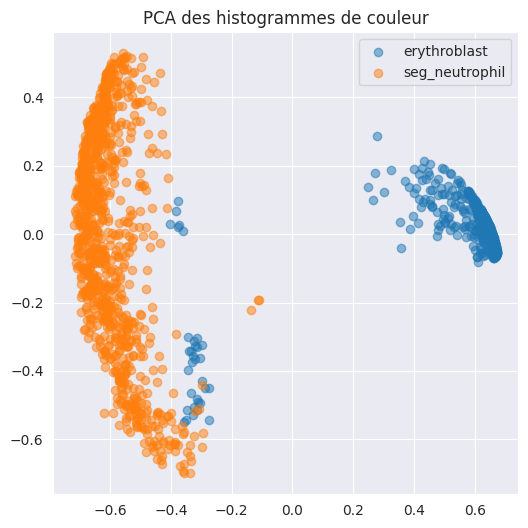

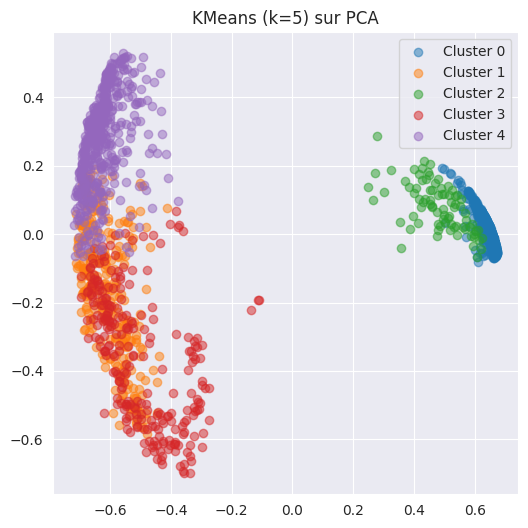

Silhouette Score: 0.44


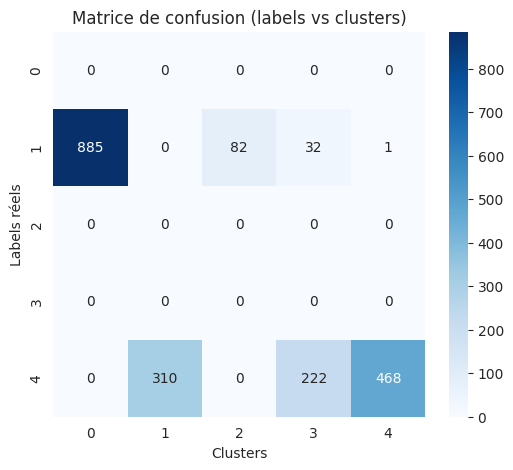

Train: 4000 | Valid: 500 | Test: 500


In [ ]:
# === Extraction de features simples (histogramme de couleurs HSV) ===
def extract_color_histogram(img_path, bins=(8, 8, 8)):
    img = cv2.imread(img_path)
    if img is None:
        return np.zeros(np.prod(bins))  # sécurité si image absente
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

# Calcul des features pour un sous-ensemble
subset_df = df.iloc[:2000]
features = np.array([extract_color_histogram(p) for p in subset_df['filepaths']])
labels_small = subset_df['label_id'].tolist()

# === PCA pour réduire à 2 dimensions ===
pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(features)
print("Variance expliquée (PCA):", pca.explained_variance_ratio_)

# Affichage PCA coloré par label
plt.figure(figsize=(6, 6))
for lbl in np.unique(labels_small):
    idxs = np.where(np.array(labels_small) == lbl)
    plt.scatter(proj[idxs, 0], proj[idxs, 1], label=inv_classes[lbl], alpha=0.5)
plt.legend()
plt.title("PCA des histogrammes de couleur")
plt.show()

# === Clustering (KMeans) sur les mêmes features ===
kmeans = KMeans(n_clusters=len(classes), random_state=42)
clusters = kmeans.fit_predict(features)

# Affichage du clustering
plt.figure(figsize=(6, 6))
for c in range(len(classes)):
    idxs = np.where(clusters == c)
    plt.scatter(proj[idxs, 0], proj[idxs, 1], label=f"Cluster {c}", alpha=0.5)
plt.legend()
plt.title(f"KMeans (k={len(classes)}) sur PCA")
plt.show()

# Évaluation du clustering
print(f"Silhouette Score: {silhouette_score(features, clusters):.2f}")

# Matrice de confusion (facultative)
conf = confusion_matrix(labels_small, clusters)
plt.figure(figsize=(6, 5))
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Clusters")
plt.ylabel("Labels réels")
plt.title("Matrice de confusion (labels vs clusters)")
plt.show()

# === Split du dataset en train, validation, test ===
# On vérifie d'abord qu'il n'y a pas de classes à un seul exemple
label_counts = df['label_id'].value_counts()
valid_labels = label_counts[label_counts >= 2].index
df_valid = df[df['label_id'].isin(valid_labels)]

paths = df_valid['filepaths'].tolist()
labels_num = df_valid['label_id'].tolist()

paths_train, paths_temp, y_train, y_temp = train_test_split(
    paths, labels_num, stratify=labels_num, test_size=0.2, random_state=42)

paths_valid, paths_test, y_valid, y_test = train_test_split(
    paths_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)

print(f"Train: {len(paths_train)} | Valid: {len(paths_valid)} | Test: {len(paths_test)}")


## Create image data generator

# Création de DataFrames

In [ ]:
# Reconstruction des DataFrames pour les générateurs
train_df = pd.DataFrame({'filepaths': paths_train, 'labels': [inv_classes[y] for y in y_train]})
valid_df = pd.DataFrame({'filepaths': paths_valid, 'labels': [inv_classes[y] for y in y_valid]})
test_df = pd.DataFrame({'filepaths': paths_test, 'labels': [inv_classes[y] for y in y_test]})


# Générateurs d'images

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuration des images
batch_size = 16
img_size = (128, 128)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Data augmentation possible ici (ex. rotation, zoom, etc.)
tr_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

ts_gen = ImageDataGenerator(rescale=1./255)

# Générateurs
train_gen = tr_gen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels',
    target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels',
    target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels',
    target_size=img_size, class_mode='categorical',
    color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 4000 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.


# Test contenu

In [ ]:
# Vérification du contenu d'un batch
x_batch, y_batch = next(train_gen)
print("Shape des images :", x_batch.shape)  # (batch_size, 128, 128, 3)
print("Shape des labels :", y_batch.shape)  # (batch_size, nb_classes)


Shape des images : (16, 128, 128, 3)
Shape des labels : (16, 5)


### Show train Data

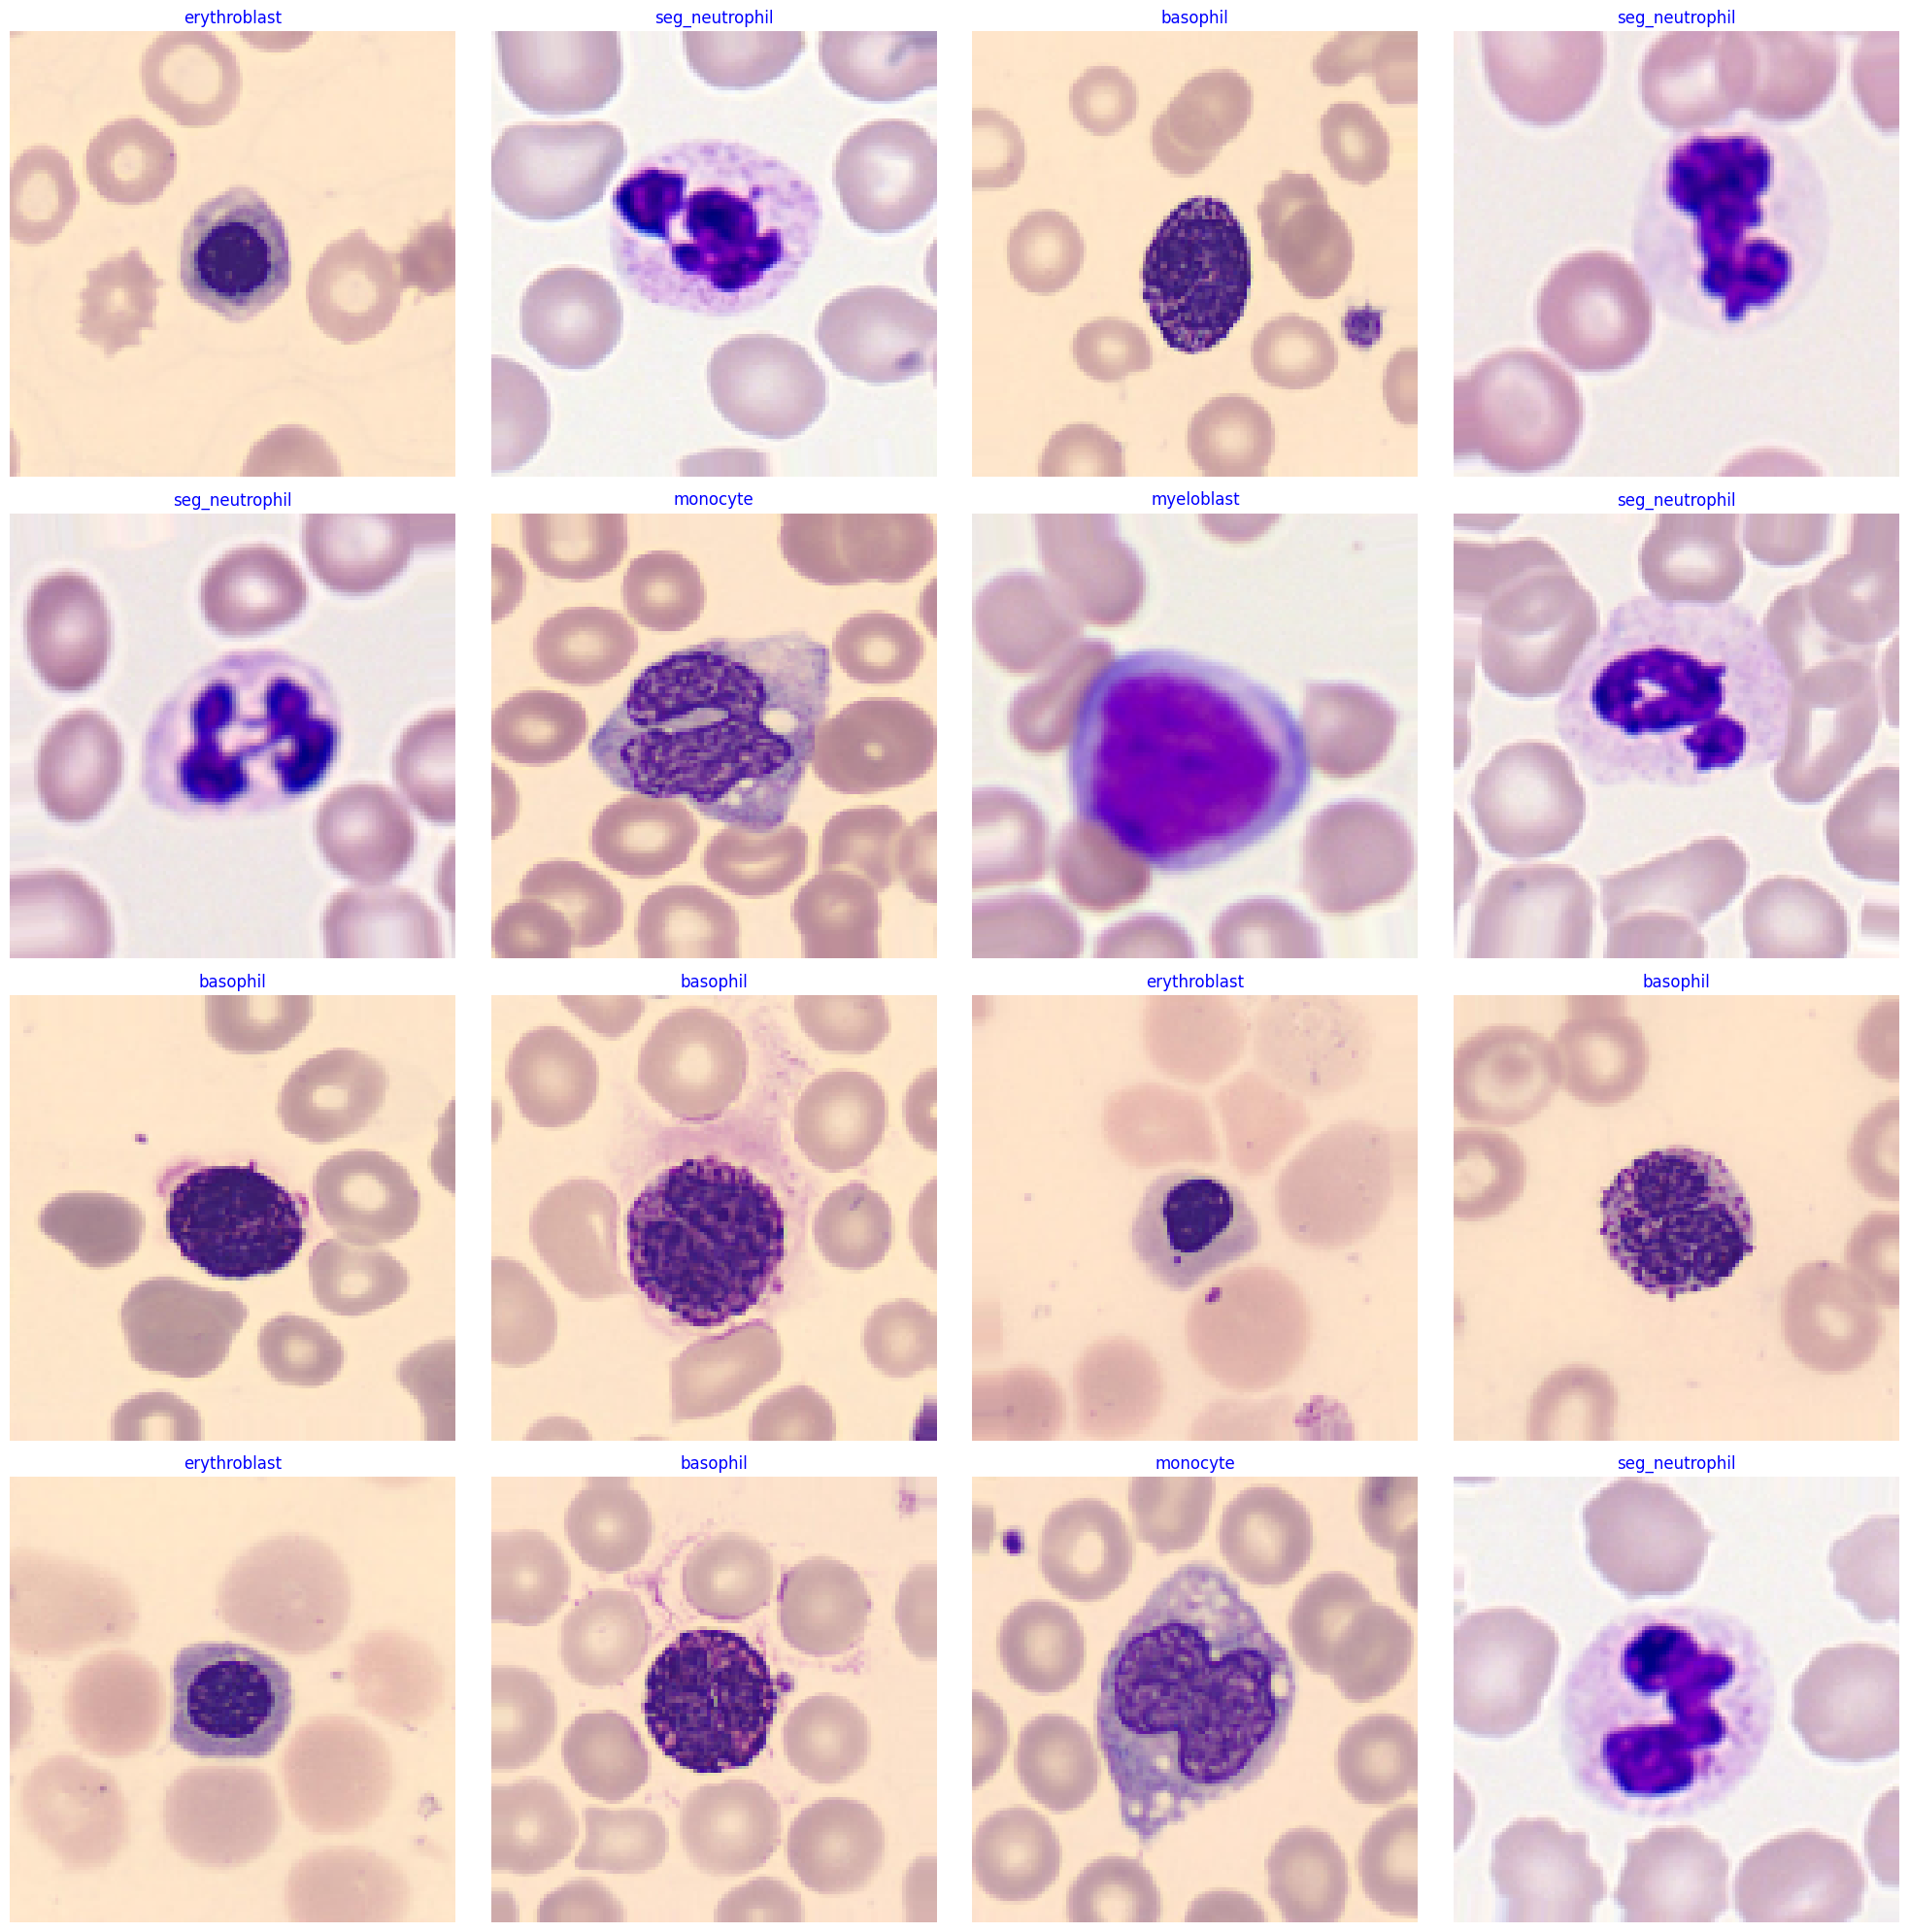

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dictionnaire des classes
g_dict = train_gen.class_indices
classes = list(g_dict.keys())

# Récupération d’un batch d’images et labels
images, labels = next(train_gen)  # images.shape = (batch_size, 128, 128, 3)

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]  # ✅ PAS de /255 ici
    plt.imshow(image)
    index = np.argmax(labels[i])  # index de la classe prédite
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()


## Model structure

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax

In [ ]:
# Création de la structure du modèle
img_size = (128, 128)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,184,436 (42.67 MB)

 Trainable params: 11,094,061 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

## Train model

In [ ]:
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 169s 158ms/step - accuracy: 0.6023 - loss: 12.2284 - val_accuracy: 0.1920 - val_loss: 6.5889
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.6529 - loss: 6.0754 - val_accuracy: 0.3460 - val_loss: 5.0946
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.7305 - loss: 4.5378 - val_accuracy: 0.7020 - val_loss: 3.6569
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.7338 - loss: 3.3570 - val_accuracy: 0.7020 - val_loss: 2.8090
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.7438 - loss: 2.5450 - val_accuracy: 0.7900 - val_loss: 2.1007
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.7495 - loss: 1.9938 - val_accuracy: 0.3480 - val_loss: 2.2675
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.7990 - loss: 1.6478 - val_accuracy: 0.7340 - val_loss: 1.5243
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.7862 - loss: 1.3964

# Display model performance

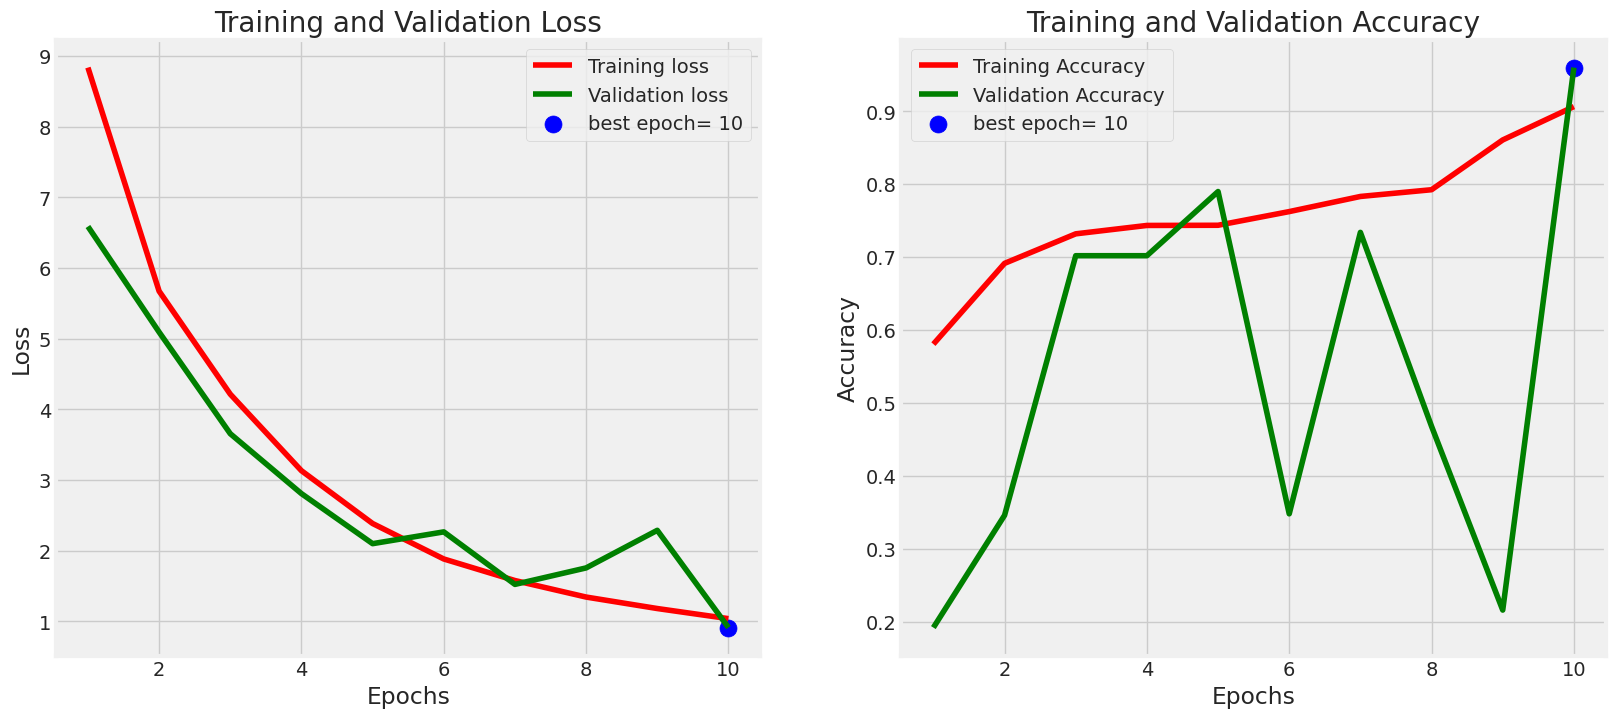

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
!pip install optuna

### Optimisation avec Optuna en lien avec Keras

In [ ]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 178.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 152.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 34.5 MB/s eta 0:00:00


**Optimisation + Cross Validation**
Barre de progression dynamique, dataframe avec tous les essais, suivi automatique dans mlflow

In [ ]:
import optuna
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import mlflow
import mlflow.tensorflow
from mlflow.models import infer_signature
import tempfile
import os

# === Paramètres ===
batch_size = 8
img_size = (128, 128)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
k_folds = 3
n_trials = 5

# === Conversion des labels string → int
label2id = {label: idx for idx, label in enumerate(sorted(df_valid['labels'].unique()))}
id2label = {v: k for k, v in label2id.items()}
df_valid['label_idx'] = df_valid['labels'].map(label2id)
num_classes = len(label2id)

# === tf.data.Dataset à partir d’un DataFrame
def df_to_tf_dataset(df, training=True):
    def load_and_preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        img = img / 255.0
        return img, tf.one_hot(label, num_classes)

    paths = df['filepaths'].values
    labels = df['label_idx'].values.astype(np.int32)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1000).repeat()
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# === Construction du modèle
def build_model(trial):
    model = models.Sequential([
        layers.Input(shape=img_shape),
        layers.Conv2D(trial.suggest_categorical("filters", [16, 32, 64]), kernel_size=3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(trial.suggest_categorical("dense_units", [32, 64, 128]), activation='relu'),
        layers.Dropout(rate=trial.suggest_float("dropout", 0.3, 0.6)),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# === Callback Optuna
class TQDMCallback:
    def __init__(self, n_trials):
        self.pbar = tqdm(total=n_trials, desc="Optuna Progress", ncols=100)
        self.records = []

    def __call__(self, study, trial):
        self.pbar.update(1)
        self.pbar.set_postfix({"Best Val_Acc": f"{study.best_value:.4f}"})
        self.records.append({'trial': trial.number, 'val_accuracy': trial.value, **trial.params})

    def close(self):
        self.pbar.close()

# === Objectif d’optimisation
def objective(trial):
    accuracies = []
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42) # Cross validation

    for train_idx, val_idx in skf.split(df_valid['filepaths'], df_valid['label_idx']):
        train_df = df_valid.iloc[train_idx]
        val_df = df_valid.iloc[val_idx]

        train_ds = df_to_tf_dataset(train_df, training=True)
        val_ds = df_to_tf_dataset(val_df, training=False)

        model = build_model(trial)

        with mlflow.start_run(nested=True):
            history = model.fit(train_ds,
                                validation_data=val_ds,
                                epochs=10,
                                steps_per_epoch=len(train_df) // batch_size,
                                validation_steps=len(val_df) // batch_size,
                                verbose=0)

            val_acc = history.history['val_accuracy'][-1]
            mlflow.log_metric("val_accuracy", val_acc)

            # Exemple d’entrée + signature
            input_example = np.random.rand(1, *img_shape).astype(np.float32)
            prediction = model.predict(input_example)
            signature = infer_signature(input_example, prediction)

            # ✅ Utilisation correcte de tempfile dans Colab
            with tempfile.TemporaryDirectory() as tmp_dir:
                mlflow.keras.save_model(model,
                                        path=tmp_dir,
                                        input_example=input_example,
                                        signature=signature)
                mlflow.log_artifacts(tmp_dir, artifact_path="model")

            # Log des classes
            mlflow.log_dict(id2label, "id2label.json")

        accuracies.append(val_acc)

    tf.keras.backend.clear_session()
    return np.mean(accuracies)

# === Lancement d’Optuna
callback = TQDMCallback(n_trials=n_trials)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials, callbacks=[callback])
callback.close()

# === Résultats
trials_df = pd.DataFrame(callback.records)
print("\n📋 Résumé des essais Optuna :")
print(trials_df)

print("\n🎯 Meilleurs hyperparamètres trouvés :")
print(study.best_params)


Optuna Progress:   0%|                                                        | 0/5 [00:00<?, ?it/s][I 2025-04-24 08:31:02,806] A new study created in memory with name: no-name-8cc47148-61ee-44e2-b6ee-867065184820


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


[I 2025-04-24 08:32:46,146] Trial 0 finished with value: 0.9336939056714376 and parameters: {'filters': 32, 'dense_units': 128, 'dropout': 0.31857588904441486}. Best is trial 0 with value: 0.9336939056714376.
Optuna Progress:  20%|█████▏                    | 1/5 [01:43<06:53, 103.34s/it, Best Val_Acc=0.9337]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


[I 2025-04-24 08:34:11,194] Trial 1 finished with value: 0.6686698744694392 and parameters: {'filters': 16, 'dense_units': 32, 'dropout': 0.3665469785796861}. Best is trial 0 with value: 0.9336939056714376.
Optuna Progress:  40%|██████████▊                | 2/5 [03:08<04:37, 92.58s/it, Best Val_Acc=0.9337]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


[I 2025-04-24 08:35:38,855] Trial 2 finished with value: 0.9302884737650553 and parameters: {'filters': 32, 'dense_units': 64, 'dropout': 0.30247829952254107}. Best is trial 0 with value: 0.9336939056714376.
Optuna Progress:  60%|████████████████▏          | 3/5 [04:36<03:00, 90.33s/it, Best Val_Acc=0.9337]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


[I 2025-04-24 08:37:11,099] Trial 3 finished with value: 0.8802083333333334 and parameters: {'filters': 32, 'dense_units': 128, 'dropout': 0.5487643436318019}. Best is trial 0 with value: 0.9336939056714376.
Optuna Progress:  80%|█████████████████████▌     | 4/5 [06:08<01:31, 91.09s/it, Best Val_Acc=0.9337]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


[I 2025-04-24 08:38:37,547] Trial 4 finished with value: 0.907852570215861 and parameters: {'filters': 16, 'dense_units': 128, 'dropout': 0.49044458079981007}. Best is trial 0 with value: 0.9336939056714376.
Optuna Progress: 100%|███████████████████████████| 5/5 [07:34<00:00, 90.95s/it, Best Val_Acc=0.9337]


📋 Résumé des essais Optuna :
   trial  val_accuracy  filters  dense_units   dropout
0      0      0.933694       32          128  0.318576
1      1      0.668670       16           32  0.366547
2      2      0.930288       32           64  0.302478
3      3      0.880208       32          128  0.548764
4      4      0.907853       16          128  0.490445

🎯 Meilleurs hyperparamètres trouvés :
{'filters': 32, 'dense_units': 128, 'dropout': 0.31857588904441486}


### Visualisations Optuna

In [ ]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate
import matplotlib.pyplot as plt



# 📈 1. Évolution de la performance au fil des essais
fig1 = plot_optimization_history(study)
fig1.update_layout(title="Historique d'optimisation", xaxis_title="Trial #", yaxis_title="Validation Accuracy")

# 📊 2. Importance des hyperparamètres
fig2 = plot_param_importances(study)
fig2.update_layout(title="Importance des hyperparamètres")

# 🧬 3. Coordonnées parallèles (relation entre params et score)
fig3 = plot_parallel_coordinate(study)
fig3.update_layout(title="Coordonnées parallèles des hyperparamètres")

# Affichage dans un notebook
fig1.show()
fig2.show()
fig3.show()


# Export en CSV des meilleurs résultats

In [ ]:
results_df = pd.DataFrame([{
    'val_accuracy': study.best_value,
    **study.best_params
}])
results_df.to_csv("best_optuna_params.csv", index=False)
print("✅ Résultats exportés dans best_optuna_params.csv")


✅ Résultats exportés dans best_optuna_params.csv


# Pipeline MLflow reproductible avec le meilleur modèle

In [ ]:
!pip install mlflow

### Entraînement final et enregistrement du modèle optimisé

---





In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_generators(train_df, valid_df):
    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=0.1, horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_dataframe(train_df,
                                                  x_col='filepaths',
                                                  y_col='labels',
                                                  target_size=img_size,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  shuffle=True,
                                                  batch_size=batch_size)

    valid_gen = test_datagen.flow_from_dataframe(valid_df,
                                                 x_col='filepaths',
                                                 y_col='labels',
                                                 target_size=img_size,
                                                 class_mode='categorical',
                                                 color_mode='rgb',
                                                 shuffle=False,
                                                 batch_size=batch_size)

    return train_gen, valid_gen


In [ ]:
import mlflow
import mlflow.tensorflow
import numpy as np


# === Lancer l'optimisation avec Optuna ===
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

best_params = study.best_params

# Division train/val finale
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df_valid, stratify=df_valid['labels'], test_size=0.2, random_state=42)

train_gen, valid_gen = create_generators(df_train, df_val)

# === 💾 Entraînement final + Log complet dans MLflow
with mlflow.start_run():
    model = models.Sequential([
        layers.Input(shape=img_shape),
        layers.Conv2D(best_params['filters'], kernel_size=3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(best_params['dense_units'], activation='relu'),
        layers.Dropout(best_params['dropout']),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(train_gen, validation_data=valid_gen, epochs=5)

    # === Logguer le modèle dans MLflow
    mlflow.keras.log_model(model, artifact_path="keras_model", registered_model_name="blood_classifier")

    # === Enregistrer H5
    model.save("Bloods.h5")
    mlflow.log_artifact("Bloods.h5")

    # === Convertir en TFLite + log
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("Bloods.tflite", "wb") as f:
        f.write(tflite_model)
    mlflow.log_artifact("Bloods.tflite")

[I 2025-04-24 08:38:40,078] A new study created in memory with name: no-name-0e1a49b7-2863-4449-b714-21c54ccab8c1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


[I 2025-04-24 08:40:08,721] Trial 0 finished with value: 0.9154647390047709 and parameters: {'filters': 16, 'dense_units': 128, 'dropout': 0.38739554236231444}. Best is trial 0 with value: 0.9154647390047709.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


[I 2025-04-24 08:41:44,496] Trial 1 finished with value: 0.7369791666666666 and parameters: {'filters': 64, 'dense_units': 64, 'dropout': 0.574359067408633}. Best is trial 0 with value: 0.9154647390047709.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


[I 2025-04-24 08:43:14,758] Trial 2 finished with value: 0.7329727510611216 and parameters: {'filters': 64, 'dense_units': 32, 'dropout': 0.41219358859883826}. Best is trial 0 with value: 0.9154647390047709.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


[I 2025-04-24 08:45:00,467] Trial 3 finished with value: 0.8930288354555765 and parameters: {'filters': 64, 'dense_units': 128, 'dropout': 0.5573075481886235}. Best is trial 0 with value: 0.9154647390047709.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


[I 2025-04-24 08:46:30,578] Trial 4 finished with value: 0.8022836446762085 and parameters: {'filters': 64, 'dense_units': 32, 'dropout': 0.5973903400531785}. Best is trial 0 with value: 0.9154647390047709.


Found 4000 validated image filenames belonging to 5 classes.
Found 1000 validated image filenames belonging to 5 classes.
Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.5385 - loss: 1.7558 - val_accuracy: 0.8790 - val_loss: 0.3468
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.7918 - loss: 0.5096 - val_accuracy: 0.9130 - val_loss: 0.2930
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.8354 - loss: 0.4156 - val_accuracy: 0.8000 - val_loss: 0.4412
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.8798 - loss: 0.3397 - val_accuracy: 0.9180 - val_loss: 0.2143
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.8885 - loss: 0.3056 - val_accuracy: 0.9320 - val_loss: 0.1759


2025/04/24 08:48:12 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/24 08:48:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'blood_classifier'.
Created version '1' of model 'blood_classifier'.


Saved artifact at '/tmp/tmpdmvg73m2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139560539558288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139560539560784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139561036359504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139560539560400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139560539555600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139561028111248: TensorSpec(shape=(), dtype=tf.resource, name=None)


## Tableau de bord MLflow en ligne

In [ ]:
# Installation des dépendances (si pas déjà fait)
!pip install mlflow pyngrok --quiet


In [ ]:

# Lancement du serveur MLflow avec tunnel ngrok
import os
import mlflow
from pyngrok import ngrok

# Spécifie le dossier local des logs MLflow
os.environ['MLFLOW_TRACKING_URI'] = 'file:/content/mlruns'

ngrok.set_auth_token("2w9P6b1iFoaUaznuEa8bmmTKPAI_3PYTjXwFQHQY5Adr9WRej")

# Démarrer le MLflow UI sur le port 5000 (en arrière-plan)
get_ipython().system_raw("mlflow ui --port 5000 &")

# Exposer ce port via ngrok
public_url = ngrok.connect(5000)
print(f"🚀 Interface MLflow accessible ici : {public_url}")






🚀 Interface MLflow accessible ici : NgrokTunnel: "https://81c8-34-87-162-47.ngrok-free.app" -> "http://localhost:5000"


## Get Predictions

Found 500 validated image filenames belonging to 5 classes.
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9612 - loss: 0.1372
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9389 - loss: 0.1637
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9521 - loss: 0.1392

🎯 Accuracy Scores
Train Accuracy     : 0.9557
Validation Accuracy: 0.9320
Test Accuracy      : 0.9420
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


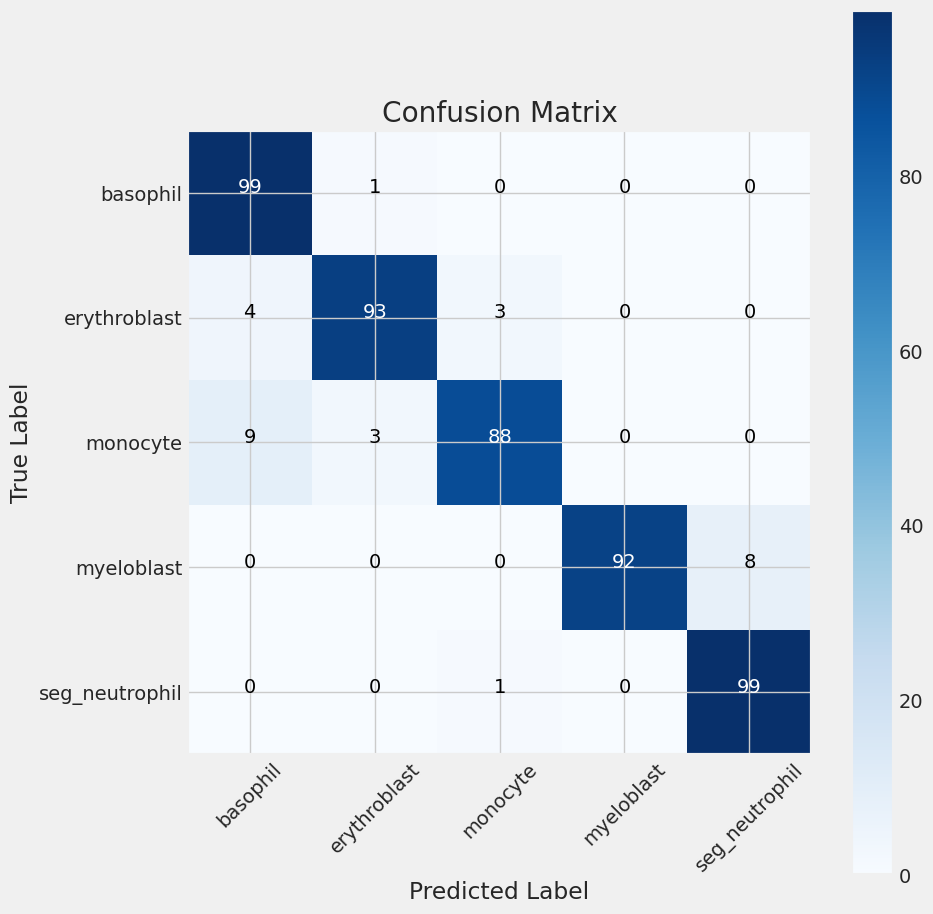


📋 Classification Report :
                precision    recall  f1-score   support

      basophil       0.88      0.99      0.93       100
  erythroblast       0.96      0.93      0.94       100
      monocyte       0.96      0.88      0.92       100
    myeloblast       1.00      0.92      0.96       100
seg_neutrophil       0.93      0.99      0.96       100

      accuracy                           0.94       500
     macro avg       0.94      0.94      0.94       500
  weighted avg       0.94      0.94      0.94       500



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import itertools
import mlflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === 0. Regénérer test_gen avec la bonne taille d’image ===
IMG_SIZE = (128, 128)  # même taille que le modèle
IMG_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=16
)
# === Évaluation du modèle sur train, validation et test ===
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score  = model.evaluate(test_gen, verbose=1)

print(f"\n🎯 Accuracy Scores")
print(f"Train Accuracy     : {train_score[1]:.4f}")
print(f"Validation Accuracy: {valid_score[1]:.4f}")
print(f"Test Accuracy      : {test_score[1]:.4f}")

# === 1. Prédictions ===
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

# === 2. Récupérer les noms de classes ===
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# === 3. Matrice de confusion ===
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Affichage des valeurs dans les cases
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

# === 4. Rapport de classification ===
print("\n📋 Classification Report :")
print(classification_report(y_true, y_pred, target_names=classes))



# === 5. Logging dans MLflow ===
with mlflow.start_run(nested=True):
    mlflow.log_metric("test_accuracy", accuracy_score(y_true, y_pred))
    mlflow.log_metric("test_f1_score_macro", f1_score(y_true, y_pred, average='macro'))
    mlflow.log_metric("test_f1_score_weighted", f1_score(y_true, y_pred, average='weighted'))
    mlflow.log_artifact("confusion_matrix.png")


# Prediction using loaded_model

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adamax

loaded_model = load_model('/content/Bloods.h5', compile=False)
loaded_model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
label2id = {label: idx for idx, label in enumerate(sorted(df_valid['labels'].unique()))}
id2label = {str(v): k for k, v in label2id.items()}  # les clés doivent être des strings si chargées depuis JSON

# Sauvegarde locale
import json
with open("id2label.json", "w") as f:
    json.dump(id2label, f, indent=4)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
✅ Prédiction : erythroblast (40.46% de confiance)


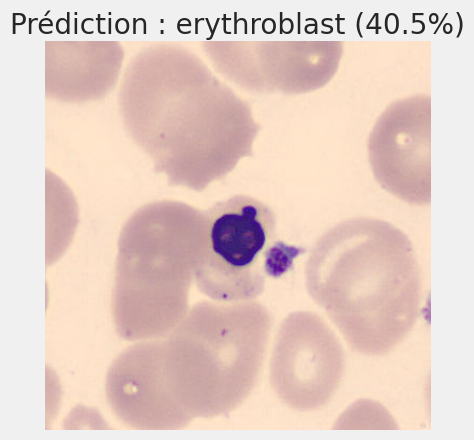

In [ ]:
import json
from PIL import Image
import tensorflow as tf
import numpy as np

# === Charger le mapping des classes
with open("id2label.json", "r") as f:
    id2label = json.load(f)

# Prétraitement de l’image
image_path = '/content/dataset/erythroblast/ERB_103778.jpg'
image = Image.open(image_path).convert("RGB")
img = image.resize((128, 128))
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
img_array = tf.expand_dims(img_array, 0)  # shape (1, 128, 128, 3)

# Prédiction
predictions = loaded_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
predicted_index = tf.argmax(score).numpy()
predicted_class = id2label[str(predicted_index)]

# Affichage
print(f"✅ Prédiction : {predicted_class} ({100 * tf.reduce_max(score):.2f}% de confiance)")

# (Optionnel) Affichage de l’image avec la prédiction
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(f"Prédiction : {predicted_class} ({100 * tf.reduce_max(score):.1f}%)")
plt.axis("off")
plt.show()


# Streamlit

In [ ]:
!pip install -q streamlit pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 172.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 180.4 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras.optimizers import Adamax
import datetime

# === Configuration de la page
st.set_page_config(page_title="Prédiction Cellule Sanguine", layout="centered")
st.title("🩸 Prédiction Cellulaire (CNN)")
st.markdown("Upload une image de cellule sanguine 👇")

# === Charger le modèle
@st.cache_resource
def load_model():
    model = tf.keras.models.load_model("Bloods.h5", compile=False)
    model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = load_model()

# === Classes connues (à adapter selon ton modèle)
class_labels = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

# === Historique en session
if "history" not in st.session_state:
    st.session_state.history = []

# === Upload d’image
uploaded_file = st.file_uploader("📁 Choisir une image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Image uploadée", use_container_width=True)

    # === Prétraitement image
    img = image.resize((128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = tf.expand_dims(img_array, 0)

    # === Prédiction
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0]).numpy()
    predicted_class = class_labels[np.argmax(score)]
    confidence = 100 * np.max(score)

    # === Top 3 classes
    top_3_idx = np.argsort(score)[-3:][::-1]
    top_3_classes = [(class_labels[i], 100 * score[i]) for i in top_3_idx]

    # === Affichage principal
    st.markdown(f"### ✅ Prédiction : `{predicted_class}` ({confidence:.2f}%)")

    # === Graphique
    st.subheader("📊 Probabilités par classe")
    df_probs = pd.DataFrame({'Classe': class_labels, 'Probabilité (%)': 100 * score})
    st.bar_chart(df_probs.set_index("Classe"))

    # === Affichage top 3
    st.markdown("#### 🥇 Top 3 prédictions")
    for label, prob in top_3_classes:
        st.write(f"- **{label}** : {prob:.2f}%")

    # ✅ Historique compatible avec affichage
    top_3_str = ", ".join([f"{lbl} ({prob:.1f}%)" for lbl, prob in top_3_classes])

    st.session_state.history.append({
      "datetime": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
      "prédiction": predicted_class,
      "confiance": f"{confidence:.2f}%",
      "top_3": top_3_str
        })

    # === Téléchargement CSV
    st.download_button("⬇️ Télécharger les résultats", df_probs.to_csv(index=False), "prediction_result.csv", "text/csv")

# === Historique global
if st.session_state.history:
    st.subheader("📁 Historique des prédictions")
    st.dataframe(pd.DataFrame(st.session_state.history))


Overwriting app.py


Test connextion Streamlit via ngrok

Vider le cache si problème de connexion

In [ ]:
!pkill streamlit
!killall ngrok


In [ ]:
!rm -f /root/.ngrok2/ngrok.yml


In [ ]:
!ngrok config add-authtoken 2w9P6b1iFoaUaznuEa8bmmTKPAI_3PYTjXwFQHQY5Adr9WRej

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
test_url = ngrok.connect(5000)
print(test_url)


NgrokTunnel: "https://75d5-34-87-162-47.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
from pyngrok import ngrok
import os

# Assure-toi que Streamlit ne tourne pas
!pkill streamlit

# Tunnel vers le port 8501 (pas besoin d'argument ici)
public_url = ngrok.connect(8501, "http")  # spécifie bien "http"
print(f"🚀 Accès à l'application : {public_url}")

# Lancer Streamlit en arrière-plan
!streamlit run app.py &>/content/logs.txt &


🚀 Accès à l'application : NgrokTunnel: "https://9f91-34-87-162-47.ngrok-free.app" -> "http://localhost:8501"
